# Gravitational waves detection

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, precision_recall_curve, roc_curve
import pandas as pd
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

## Data reading

In [4]:
filename = "C:/Users/ISAFA/Desktop/sample_2e7_design_precessing_higherordermodes_3detectors.h5"
f = h5py.File(filename)

N=int(1e5) #Number of data that I take

data=[]
for i in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z']:
    data.append(f[i][:N])
    
data = np.array(data).T

detect = np.array(f['det'][:N]) #The source is detected or not? 0=no, 1=yes

In [5]:
data.shape

(100000, 13)

In [6]:
no=0
yes=0

for i in detect:    
    if i==0:
        no += 1
    else:
        yes += 1
        
print('The detected sources are:', yes)
print('The sources not detected are:', no)

The detected sources are: 14382
The sources not detected are: 85618


## Split the data in train and test

In [7]:
Data_train, Data_test, Detect_train, Detect_test = train_test_split(data, detect, test_size=0.25, random_state=0)

## Decision tree

Decision trees requires a max_depth parameter to impose. We can choose it through cross-validation. We split the train dataset to leave the test one for the final test.

In [9]:
n = 10 #Number of splits
depths = np.arange(1, 16, dtype=int)

accuracy_cv_array = np.empty(len(depths))
precision_cv_array = np.empty(len(depths))
completeness_cv_array = np.empty(len(depths))

kf = KFold(n_splits=n, shuffle=True, random_state=123)     #Create the indexes for the split in train and test data
                                                               #With random_state fixed we have always the same split, so data are reproducible  
for i, depth in tqdm(enumerate(depths)):
    
    accuracy = []
    precision = []
    completeness = []
    
    for (train_index, test_index) in kf.split(Data_train): #Divide the redshifts data in the folds
        data_train, data_test = Data_train[train_index], Data_train[test_index]
        detect_train, detect_test = Detect_train[train_index], Detect_train[test_index]
    
        dtree = DecisionTreeClassifier(max_depth=depth)
        dtree.fit(data_train, detect_train)
        detect_pred = dtree.predict(data_test)
        
        accuracy.append(accuracy_score(detect_test, detect_pred))
        precision.append(precision_score(detect_test, detect_pred))
        completeness.append(recall_score(detect_test, detect_pred))

    accuracy_cv_array[i] = np.mean(accuracy)
    precision_cv_array[i] = np.mean(precision)
    completeness_cv_array[i] = np.mean(completeness)       

0it [00:00, ?it/s]

Now we plot the results:

In [10]:
data = {
    'Depth': depths,
    'Accuracy': accuracy_cv_array,
    'Precision': precision_cv_array,
    'Completeness':completeness_cv_array,
}
df = pd.DataFrame(data)
display(df)

,Depth,Accuracy,Precision,Completeness
0,1,0.932147,0.738625,0.815610
1,2,0.932147,0.738625,0.815610
2,3,0.939507,0.782521,0.800820
3,4,0.946600,0.812971,0.814993
4,5,0.950520,0.831116,0.822144
5,6,0.952827,0.826678,0.848908
6,7,0.956507,0.868746,0.821354
7,8,0.957467,0.855486,0.846406
8,9,0.957027,0.858500,0.838464
9,10,0.956053,0.851991,0.839280


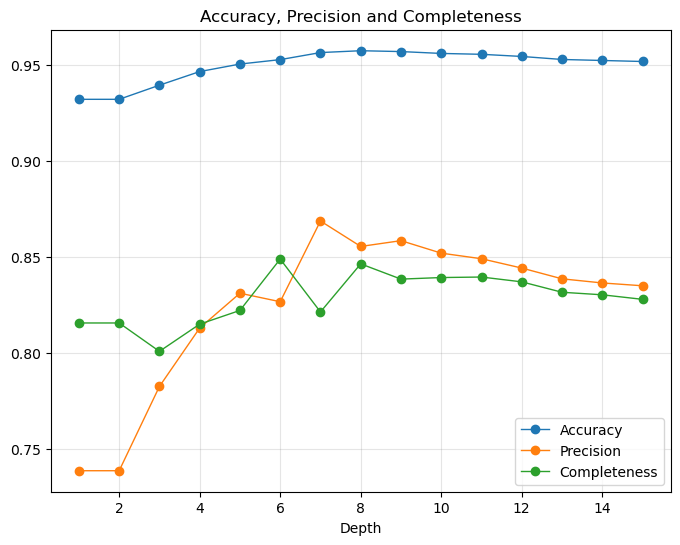

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.grid(c='grey', alpha = 0.2)
ax.set_title('Accuracy, Precision and Completeness')
ax.set_xlabel('Depth')
ax.plot(depths, accuracy_cv_array, label = 'Accuracy', marker = 'o', lw = 1)
ax.plot(depths, precision_cv_array, label = 'Precision', marker = 'o', lw = 1)
ax.plot(depths, completeness_cv_array, label = 'Completeness', marker = 'o', lw = 1)
ax.legend()

The accuracy is the proportion of total predictions that were correct, the completeness is the rate of true positive and the precision is one minus the false discovery rate (contamination). Depending on the request, we require to maximaze one of these or a combination of them.

In [12]:
best_acc = np.argmax(accuracy_cv_array)
best_prec = np.argmax(precision_cv_array)
best_comp = np.argmax(completeness_cv_array)
print('The best accuracy is for a depth =', best_acc+1)
print('The best precision is for a depth =', best_prec+1)
print('The best completeness is for a depth =', best_comp+1)

The best accuracy is for a depth = 8
The best precision is for a depth = 7
The best completeness is for a depth = 6


We can try another cross validation method through GridSearchCV.

In [24]:
dtree = DecisionTreeClassifier()
drange = np.arange(1, 16)  

grid = GridSearchCV(dtree, param_grid={'max_depth': drange}, cv=5) 
grid.fit(Data_train, Detect_train)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best parameter choice: 8


We can try the method with 6, 7 and 8 depths.

In [26]:
best_depths=[6, 7, 8]
    
accuracy_dtree_train = np.empty(3)
precision_dtree_train = np.empty(3)
completeness_dtree_train = np.empty(3)
contamination_dtree_train = np.empty(3)
confusion_matrix_train = np.empty(4)
tn_train_dtree = np.empty(3) 
fp_train_dtree = np.empty(3) 
fn_train_dtree = np.empty(3) 
tp_train_dtree = np.empty(3)

accuracy_dtree_test = np.empty(3)
precision_dtree_test = np.empty(3)
completeness_dtree_test = np.empty(3)
contamination_dtree_test = np.empty(3)
confusion_matrix_test = np.empty(3)
tn_test_dtree = np.empty(3) 
fp_test_dtree = np.empty(3) 
fn_test_dtree = np.empty(3) 
tp_test_dtree = np.empty(3)

for i in range(len(best_depths)):
    dtree = DecisionTreeClassifier(max_depth=best_depths[i], random_state=123)
    dtree.fit(Data_train, Detect_train)
    Detect_pred_test = dtree.predict(Data_test)
    Detect_pred_train = dtree.predict(Data_train)

    accuracy_dtree_test[i] = accuracy_score(Detect_test, Detect_pred_test)
    precision_dtree_test[i] = precision_score(Detect_test, Detect_pred_test)
    completeness_dtree_test[i] = recall_score(Detect_test, Detect_pred_test)
    contamination_dtree_test[i] = 1- precision_score(Detect_test, Detect_pred_test)
    conf_matrix_test = confusion_matrix(Detect_test, Detect_pred_test)
    tn_test_dtree[i], fp_test_dtree[i], fn_test_dtree[i], tp_test_dtree[i] = conf_matrix_test.ravel()

    accuracy_dtree_train[i] = accuracy_score(Detect_train, Detect_pred_train)
    precision_dtree_train[i] = precision_score(Detect_train, Detect_pred_train)
    completeness_dtree_train[i] = recall_score(Detect_train, Detect_pred_train)
    contamination_dtree_train[i] = 1- precision_score(Detect_train, Detect_pred_train)
    conf_matrix_train = confusion_matrix(Detect_train, Detect_pred_train)
    tn_train_dtree[i], fp_train_dtree[i], fn_train_dtree[i], tp_train_dtree[i] = conf_matrix_train.ravel()
    

In [27]:
data_train = {
    'Depth': best_depths,
    'Accuracy': accuracy_dtree_train, 
    'Precision': precision_dtree_train,
    'Completeness':completeness_dtree_train, 
    'Contamination': contamination_dtree_train,
    'True positives': tp_train_dtree,
    'False positives': fp_train_dtree,
    'False negatives': fn_train_dtree,
    'True negatives': tn_train_dtree,
}
df_tr = pd.DataFrame(data_train)
df_tr = df_tr.round(2)
display(Markdown("### Results of decision tree classification on train dataset:"))
display(df_tr)

data_test = {
    'Depth': best_depths,
    'Accuracy': accuracy_dtree_test, 
    'Precision': precision_dtree_test,
    'Completeness':completeness_dtree_test, 
    'Contamination': contamination_dtree_test,
    'True positives': tp_test_dtree,
    'False positives': fp_test_dtree,
    'False negatives': fn_test_dtree,
    'True negatives': tn_test_dtree,
}
df_t_dtree = pd.DataFrame(data_test)
df_t_dtree = df_t_dtree.round(2)
display(Markdown("### Results of decision tree classification on test dataset:"))
display(df_t_dtree)

### Results of decision tree classification on train dataset:

,Depth,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,6,0.96,0.83,0.87,0.17,9370.0,1875.0,1378.0,62377.0
1,7,0.96,0.89,0.84,0.11,9058.0,1125.0,1690.0,63127.0
2,8,0.97,0.89,0.88,0.11,9436.0,1212.0,1312.0,63040.0


### Results of decision tree classification on test dataset:

,Depth,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,6,0.95,0.82,0.86,0.18,3118.0,671.0,516.0,20695.0
1,7,0.96,0.87,0.81,0.13,2959.0,441.0,675.0,20925.0
2,8,0.96,0.85,0.84,0.15,3059.0,521.0,575.0,20845.0


In terms of accuracy, precision, completeness and contamaination the results are quiete similar. If we want to find a compromise among them I would choose depth = 8.

## Bagging keeping the same depth

In [28]:
best_depths=[6, 7, 8]
    
accuracy_dbag_train = np.empty(3)
precision_dbag_train = np.empty(3)
completeness_dbag_train = np.empty(3)
contamination_dbag_train = np.empty(3)
confusion_matrix_train = np.empty(3)
tn_train_dbag = np.empty(3) 
fp_train_dbag = np.empty(3) 
fn_train_dbag = np.empty(3) 
tp_train_dbag = np.empty(3)

accuracy_dbag_test = np.empty(3)
precision_dbag_test = np.empty(3)
completeness_dbag_test = np.empty(3)
contamination_dbag_test = np.empty(3)
confusion_matrix_test = np.empty(3)
tn_test_dbag = np.empty(3) 
fp_test_dbag = np.empty(3) 
fn_test_dbag = np.empty(3) 
tp_test_dbag = np.empty(3)

for i in range(len(best_depths)):
    dbag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth = best_depths[i], random_state=42), n_estimators=500, max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)
    dbag_clf.fit(Data_train, Detect_train)
    Detect_pred_test = dbag_clf.predict(Data_test)
    Detect_pred_train = dbag_clf.predict(Data_train)

    accuracy_dbag_test[i] = accuracy_score(Detect_test, Detect_pred_test)
    precision_dbag_test[i] = precision_score(Detect_test, Detect_pred_test)
    completeness_dbag_test[i] = recall_score(Detect_test, Detect_pred_test)
    contamination_dbag_test[i] = 1- precision_score(Detect_test, Detect_pred_test)
    conf_matrix_test = confusion_matrix(Detect_test, Detect_pred_test)
    tn_test_dbag[i], fp_test_dbag[i], fn_test_dbag[i], tp_test_dbag[i] = conf_matrix_test.ravel()

    accuracy_dbag_train[i] = accuracy_score(Detect_train, Detect_pred_train)
    precision_dbag_train[i] = precision_score(Detect_train, Detect_pred_train)
    completeness_dbag_train[i] = recall_score(Detect_train, Detect_pred_train)
    contamination_dbag_train[i] = 1- precision_score(Detect_train, Detect_pred_train)
    conf_matrix_train = confusion_matrix(Detect_train, Detect_pred_train)
    tn_train_dbag[i], fp_train_dbag[i], fn_train_dbag[i], tp_train_dbag[i] = conf_matrix_train.ravel()

In [29]:
data_train = {
    'Depth': best_depths,
    'Accuracy': accuracy_dbag_train, 
    'Precision': precision_dbag_train,
    'Completeness':completeness_dbag_train, 
    'Contamination': contamination_dbag_train,
    'True positives': tp_train_dbag,
    'False positives': fp_train_dbag,
    'False negatives': fn_train_dbag,
    'True negatives': tn_train_dbag,
}
df_tr = pd.DataFrame(data_train)
df_tr = df_tr.round(2)
display(Markdown("### Results of decision tree classification with bagging on train dataset:"))
display(df_tr)

data_test = {
    'Depth': best_depths,
    'Accuracy': accuracy_dbag_test, 
    'Precision': precision_dbag_test,
    'Completeness':completeness_dbag_test, 
    'Contamination': contamination_dbag_test,
    'True positives': tp_test_dbag,
    'False positives': fp_test_dbag,
    'False negatives': fn_test_dbag,
    'True negatives': tn_test_dbag,
}
df_t_dbag = pd.DataFrame(data_test)
df_t_dbag = df_t_dbag.round(2)
display(Markdown("### Results of decision tree classification with bagging on test dataset:"))
display(df_t_dbag)

### Results of decision tree classification with bagging on train dataset:

,Depth,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,6,0.94,0.81,0.77,0.19,8226.0,1936.0,2522.0,62316.0
1,7,0.94,0.81,0.77,0.19,8224.0,1933.0,2524.0,62319.0
2,8,0.94,0.81,0.77,0.19,8223.0,1932.0,2525.0,62320.0


### Results of decision tree classification with bagging on test dataset:

,Depth,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,6,0.94,0.83,0.78,0.17,2839.0,597.0,795.0,20769.0
1,7,0.94,0.83,0.78,0.17,2839.0,599.0,795.0,20767.0
2,8,0.94,0.83,0.78,0.17,2837.0,598.0,797.0,20768.0


The four depths give us almost identical results using bagging.

## Random Forest

In [20]:
forest = RandomForestClassifier(criterion='entropy', class_weight='balanced', n_jobs=-1)
drange = np.arange(1, 20)  

grid = GridSearchCV(forest, param_grid={'max_depth': drange}, cv=5) 
grid.fit(Data_train, Detect_train)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best parameter choice: 19


In [21]:
best_forest = 19
forest = RandomForestClassifier(n_estimators=200, max_depth=best_forest, criterion='entropy', n_jobs=-1)
forest.fit(Data_train, Detect_train)
Detect_pred_test = forest.predict(Data_test)
Detect_pred_train = forest.predict(Data_train)

accuracy_forest_test = accuracy_score(Detect_test, Detect_pred_test)
precision_forest_test = precision_score(Detect_test, Detect_pred_test)
completeness_forest_test = recall_score(Detect_test, Detect_pred_test)
contamination_forest_test = 1- precision_score(Detect_test, Detect_pred_test)
conf_matrix_test = confusion_matrix(Detect_test, Detect_pred_test)
tn_test_forest, fp_test_forest, fn_test_forest, tp_test_forest = conf_matrix_test.ravel()

accuracy_forest_train = accuracy_score(Detect_train, Detect_pred_train)
precision_forest_train = precision_score(Detect_train, Detect_pred_train)
completeness_forest_train = recall_score(Detect_train, Detect_pred_train)
contamination_forest_train = 1- precision_score(Detect_train, Detect_pred_train)
conf_matrix_train = confusion_matrix(Detect_train, Detect_pred_train)
tn_train_forest, fp_train_forest, fn_train_forest, tp_train_forest = conf_matrix_train.ravel()

In [22]:
data_train = {
    'Depth': [best_forest],
    'Accuracy': [accuracy_forest_train], 
    'Precision': [precision_forest_train],
    'Completeness':[completeness_forest_train], 
    'Contamination': [contamination_forest_train],
    'True positives': [tp_train_forest],
    'False positives': [fp_train_forest],
    'False negatives': [fn_train_forest],
    'True negatives': [tn_train_forest],
}
df_tr = pd.DataFrame(data_train)
df_tr = df_tr.round(2)
display(Markdown("### Results of Random forest on train dataset:"))
display(df_tr)

data_test = {
    'Detph': [best_forest],
    'Accuracy': accuracy_forest_test, 
    'Precision': precision_forest_test,
    'Completeness':completeness_forest_test, 
    'Contamination': contamination_forest_test,
    'True positives': tp_test_forest,
    'False positives': fp_test_forest,
    'False negatives': fn_test_forest,
    'True negatives': tn_test_forest,
}
df_t_forest = pd.DataFrame(data_test)
df_t_forest = df_t_forest.round(2)
display(Markdown("### Results of Random Forest on test dataset:"))
display(df_t_forest)

### Results of Random forest on train dataset:

,Depth,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,19,1.0,1.0,1.0,0.0,10737,14,11,64238


### Results of Random Forest on test dataset:

,Detph,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,19,0.97,0.91,0.86,0.09,3117,305,517,21061


## Results so far

In [30]:
display(Markdown("### Results of decision tree classification on test dataset:"))
display(df_t_dtree)

display(Markdown("### Results of decision tree classification with bagging on test dataset:"))
display(df_t_dbag)

display(Markdown("### Results of Random Forest on test dataset:"))
display(df_t_forest)

### Results of decision tree classification on test dataset:

,Depth,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,6,0.95,0.82,0.86,0.18,3118.0,671.0,516.0,20695.0
1,7,0.96,0.87,0.81,0.13,2959.0,441.0,675.0,20925.0
2,8,0.96,0.85,0.84,0.15,3059.0,521.0,575.0,20845.0


### Results of decision tree classification with bagging on test dataset:

,Depth,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,6,0.94,0.83,0.78,0.17,2839.0,597.0,795.0,20769.0
1,7,0.94,0.83,0.78,0.17,2839.0,599.0,795.0,20767.0
2,8,0.94,0.83,0.78,0.17,2837.0,598.0,797.0,20768.0


### Results of Random Forest on test dataset:

,Detph,Accuracy,Precision,Completeness,Contamination,True positives,False positives,False negatives,True negatives
0,19,0.97,0.91,0.86,0.09,3117,305,517,21061


The best method if we look at everything is the Random Forest classifier.